# Transcription factor activity with Decoupler


## Data

<div style="padding-top: 10px; font-size: 15px;">
We'll start from the previously saved AnnData of metacells that we called `3_CellrankAdata.h5ad`
If you didn't manage to save it, you can copy it in your fodlers from the shared one. Open a terminal and copy this command (changing the path to the shared folder):
</div>

```
rsync <PATH/TO/SHARED/FOLDER>/3_CellrankAdata.h5ad $HOME/BrainOmics2024/2_Day2
```

## Notebook content
<div style="padding-top: 10px; font-size: 15px;">
    <ul>
        <li>TF activity computation with Decoupler </li>
        <li>TF activity along trajectories - Combining Decoupler and CellRank</li>
</ul>

</div>

<div style="padding-top: 10px; font-size: 15px;">
Decoupler overview:

<div>
  <img src="https://decoupler-py.readthedocs.io/en/latest/_images/graphical_abstract.png" width="800">
</div>

Reference: <a href="https://academic.oup.com/bioinformaticsadvances/article/2/1/vbac016/6544613">decoupleR: ensemble of computational methods to infer biological activities from omics data</a>

From the homepage of the <a href="https://decoupler-py.readthedocs.io/en/latest/">Documentation</a>
> `decoupler` is a package containing different **statistical methods** to extract biological activities from omics data within a unified framework. It allows to flexibly test any enrichment method with any prior knowledge resource and incorporates methods that take into account the sign and weight.

It also wrap many utilities for <a href="https://decoupler-py.readthedocs.io/en/latest/notebooks/pseudobulk.html">pseudobulk analysis</a> , <a href="https://decoupler-py.readthedocs.io/en/latest/notebooks/msigdb.html">functional enrichment and databases access</a>, <a href="https://decoupler-py.readthedocs.io/en/latest/notebooks/translate.html">genes' names conversion</a>

Today we will focus on Transcription Factor (TF) activity inference. A tutorial for this can be found <a href="https://decoupler-py.readthedocs.io/en/latest/notebooks/dorothea.html">here</a> 

---

# Library loading

In [1]:
import scanpy as sc, anndata as ad, numpy as np, pandas as pd
import warnings
import yaml
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy.external as sce
import scipy.sparse as sp
import statsmodels.api as sm
import scanpy as sc
import cellrank as cr
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

from sklearn_extra.cluster import KMedoids

import matplotlib.pyplot 
import scanpy.external as sce
from matplotlib.colors import TwoSlopeNorm
import warnings
warnings.filterwarnings('ignore')

from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy import stats
warnings.filterwarnings('ignore')
import scvelo as scv
import plotly.express as px
import plotly.io as pio
import itertools
import decoupler as dc
import sys
pio.renderers.default = "jupyterlab"
import random
random.seed(1)


In [2]:
homeDir = os.getenv("HOME")

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

import matplotlib.pyplot as plt
sys.path.insert(1, "./utils/")


from CleanAdata import *
from SankeyOBS import *


scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.26.4 scipy==1.11.4 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.12


# Load Metacells Anndata

In [20]:
CombinedAdata = sc.read_h5ad("./3_CellrankAdata.h5ad")

# Compute TF activity

<div style="padding-top: 10px; font-size: 15px;">
We will compute the transcription factor activity based on the gene expression of their target as imputed by MAGIC, in order to have a more clean signal. Each transcription factor activity will be computed as a <a href="https://decoupler-py.readthedocs.io/en/latest/generated/decoupler.run_ulm.html#decoupler.run_ulm">Univariate Linear Model</a> of the weighted expression of its targets. The targets and its weight are determined by an external source, in our case <a href="https://github.com/saezlab/CollecTRI">CollecTRI</a> but you could use other resources such as <a href="https://saezlab.github.io/dorothea/">Dorothea</a>.

In [6]:
CombinedAdata.X = CombinedAdata.layers["MAGIC_imputed_data"].copy()

# Download database of regulons
net = dc.get_collectri(organism='human', split_complexes=False)
net
net

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;2...
...,...,...,...,...
43173,NFKB,hsa-miR-143-3p,1,19472311
43174,AP1,hsa-miR-206,1,19721712
43175,NFKB,hsa-miR-21-5p,1,20813833;22387281
43176,NFKB,hsa-miR-224-5p,1,23474441;23988648


<div style="padding-top: 10px; font-size: 15px;">
We run the model, fitting it on each cell's imputed gene expression. The activity will be inferred from the t-value of the slope:

<div>
  <img src="https://decoupler-py.readthedocs.io/en/latest/_images/ulm.png" width="800">
</div>

In [7]:
dc.run_ulm(
    mat=CombinedAdata,
    net=net,use_raw=False, 
    source='source',
    target='target',
    weight='weight',
    verbose=True
)

46 features of mat are empty, they will be removed.
Running ulm on mat with 3200 samples and 16278 targets for 668 sources.


<div style="padding-top: 10px; font-size: 15px;">
In the end we'll have a score for each TF in each cell, that will be extracted and stored in a new AnnData using the `get_acts()` function.

In [8]:
acts = dc.get_acts(CombinedAdata, obsm_key='ulm_estimate')
acts

AnnData object with n_obs × n_vars = 3200 × 668
    obs: 'kmeans_clusters', 'AggregatedClass', 'AggregatedLabel', 'Auth_Sample.ID', 'Auth_Age', 'Auth_Tissue.ID', 'Auth_Sample.Type', 'Auth_Assay', 'Auth_Batch', 'dataset_id', 'sample_id', 'brain_region', 'age', 'stage', 'batch_key', 'Auth_Assay_formatted', 'scDblFinder.class', 'palantir_pseudotime', 'palantir_entropy', 'ct_score', 'ct_pseudotime', 'ct_num_exp_genes', 'macrostates_fwd', 'init_states_fwd', 'init_states_fwd_probs', 'term_states_fwd', 'term_states_fwd_probs'
    uns: 'AggregatedClass_colors', 'AggregatedLabel_colors', 'Auth_Age_colors', 'Auth_Batch_colors', 'Auth_Sample.ID_colors', 'DM_EigenValues', 'coarse_fwd', 'ct_params', 'draw_graph', 'eigendecomposition_fwd', 'init_states_fwd_colors', 'macrostates_fwd_colors', 'neighbors', 'palantir_waypoints', 'rank_genes_groups', 'schur_matrix_fwd', 'term_states_fwd_colors'
    obsm: 'DM_EigenVectors', 'DM_EigenVectors_multiscaled', 'X_draw_graph_fa', 'X_pca', 'X_pca_harmony', 'branc

<div style="padding-top: 10px; font-size: 15px;">
For each cell type we can compute the "marker TF" using the <code>rank_sources_groups()</code> function, a wrapper of the <code>rank_genes_groups()</code> function from Scanpy. We can then inspect the top active TF and the less active TF for each group:

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_AggregatedClass']`


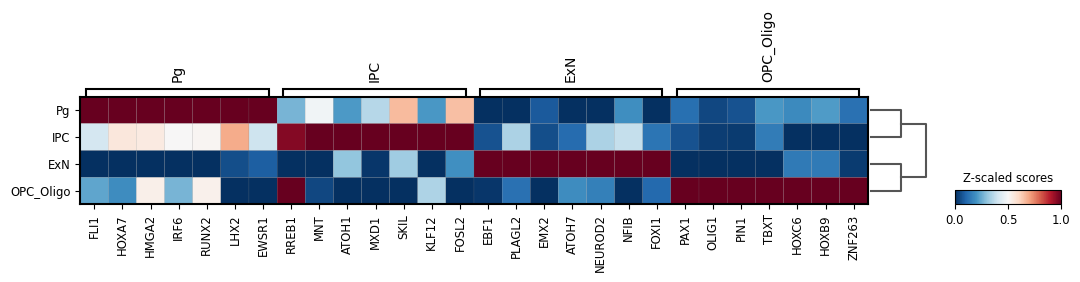

In [9]:
df = dc.rank_sources_groups(acts, groupby='AggregatedClass', reference='rest', method='t-test_overestim_var')
n_markers = 7
source_markers = df.groupby('group').head(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
source_markers
sc.pl.matrixplot(acts, source_markers, 'AggregatedClass', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

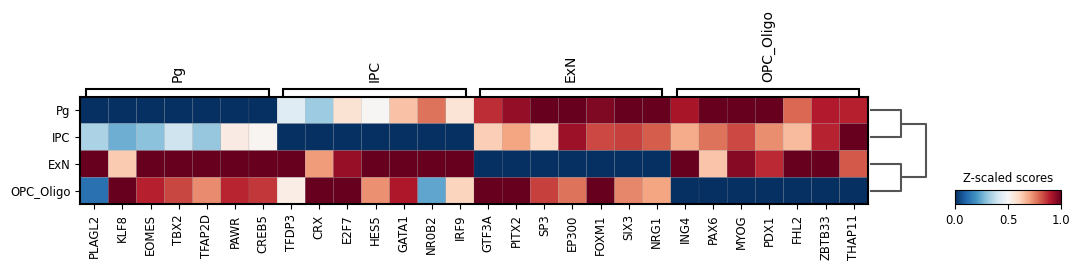

In [10]:
dfdown = dc.rank_sources_groups(acts, groupby='AggregatedClass', reference='rest', method='t-test_overestim_var')
n_markers = 7
source_markersDOWN = dfdown.groupby('group').tail(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
source_markersDOWN
sc.pl.matrixplot(acts, source_markersDOWN, 'AggregatedClass', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

<div style="padding-top: 10px; font-size: 15px;">
Let's see these top markers in the draw graph space:

In [11]:
UpandDOwnMarkers = {celltype:[source_markersDOWN[celltype][0]]+[source_markers[celltype][0]] for celltype in list(source_markersDOWN.keys())}

ExN


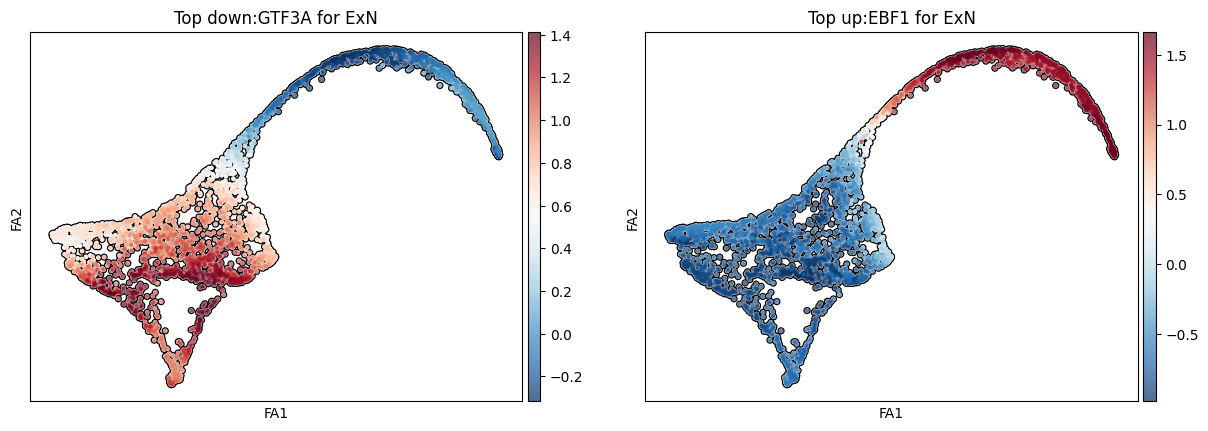

IPC


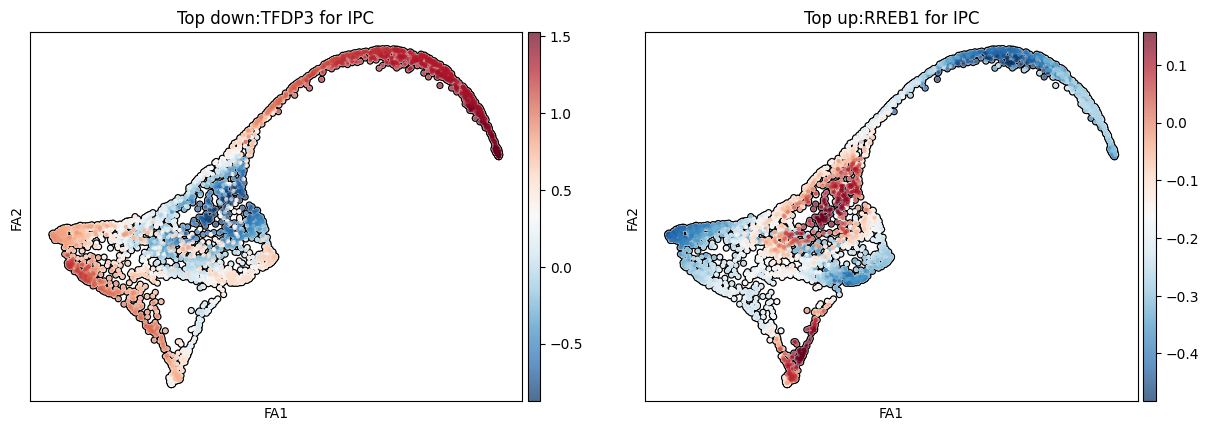

OPC_Oligo


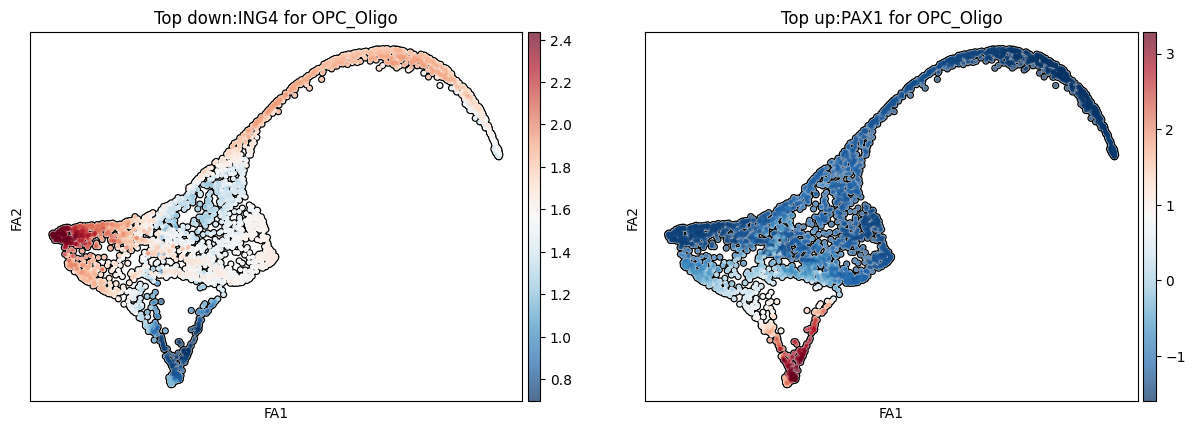

Pg


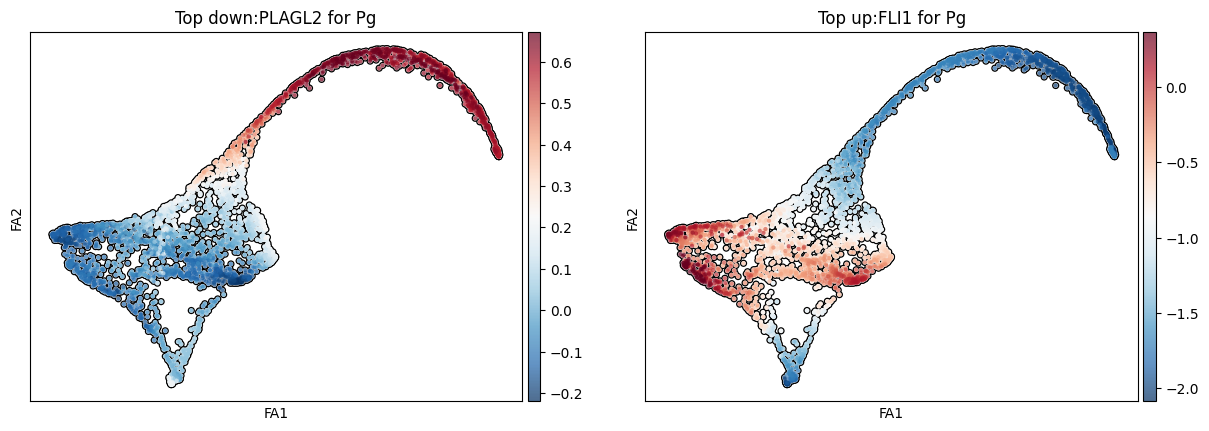

In [12]:
for k in UpandDOwnMarkers.keys():
    print(k)
    sc.pl.draw_graph(acts, color=UpandDOwnMarkers[k], cmap='RdBu_r',  add_outline=True, ncols=2, vmin='p1', vmax='p99', 
                     title=["Top down:{} for {}".format(UpandDOwnMarkers[k][0], k), "Top up:{} for {}".format(UpandDOwnMarkers[k][1], k)])

# Combining TF activity with CellRank

<div style="padding-top: 10px; font-size: 15px;">
We load the model that we previously trained to infer the macrostate from our combined kernel of pseudotime (Palantir output), pluripotency score (CytoTrace output) and transcriptional similarity and compute once again the macrostates and fate probabilities:

In [21]:
import pickle

with open('./GPCCA.pickle', 'rb') as file:
    g = pickle.load(file)

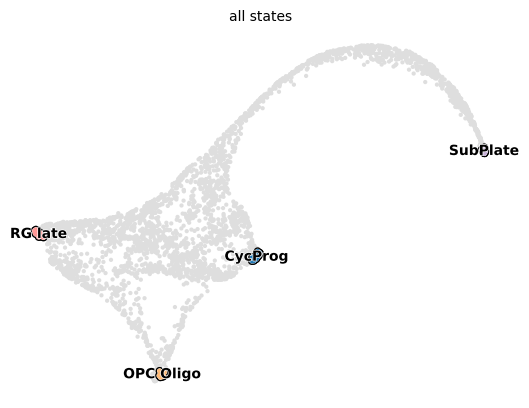

  0%|          | 0/3 [00:00<?, ?/s]

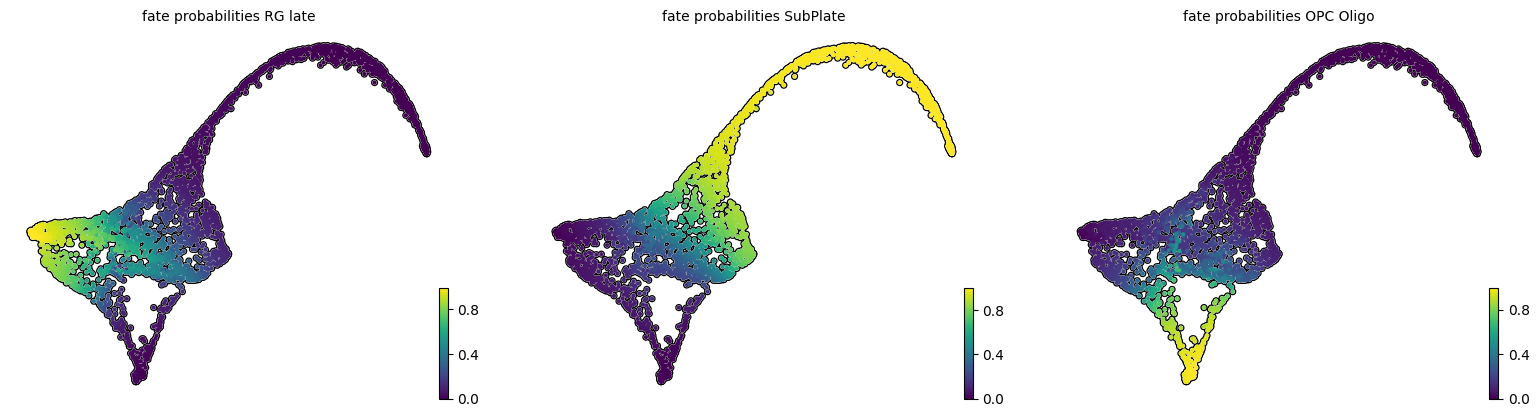

In [14]:
g.fit(n_states=4, cluster_key="AggregatedLabel")
g.plot_macrostates(which="all", basis="X_draw_graph_fa")
g.set_initial_states("CycProg")
g.set_terminal_states(["RG_late", "SubPlate","OPC_Oligo"])
g.compute_fate_probabilities()
g.plot_fate_probabilities(basis="X_draw_graph_fa", same_plot=False, add_outline=True)

<div style="padding-top: 10px; font-size: 15px;">
    
Again we can determing trends of expression fitting a GAM model. Here however we will determine trends in TF activity along trajectories:

In [15]:
g.adata = g.adata[acts.obs_names,0:acts.shape[1]]
g.adata.var_names = acts.var_names
g.X = acts.X.copy()

In [16]:
acts.uns = g.adata.uns.copy()
acts.obsm = g.adata.obsm.copy()
acts.obs = g.adata.obs.copy()

ERROR: Unable to duplicate function call using shadow `anndata.AnnData` object. Reason: `value.index does not match parent’s var names:
Index are different

Index length are different
[left]:  668, Index(['ABL1', 'AHR', 'AIRE', 'AP1', 'APEX1', 'AR', 'ARID1A', 'ARID3A',
       'ARID3B', 'ARID4A',
       ...
       'ZNF350', 'ZNF354C', 'ZNF362', 'ZNF382', 'ZNF384', 'ZNF395', 'ZNF436',
       'ZNF699', 'ZNF76', 'ZNF91'],
      dtype='object', length=668)
[right]: 16324, Index(['ENSG00000238009', 'LINC01409', 'LINC00115', 'FAM41C',
       'ENSG00000230699', 'NOC2L', 'KLHL17', 'ENSG00000272512', 'HES4',
       'ISG15',
       ...
       'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4',
       'MT-ND5', 'MT-ND6', 'MT-CYB'],
      dtype='object', name='external_gene_name', length=16324)`


  0%|          | 0/40 [00:00<?, ?gene/s]

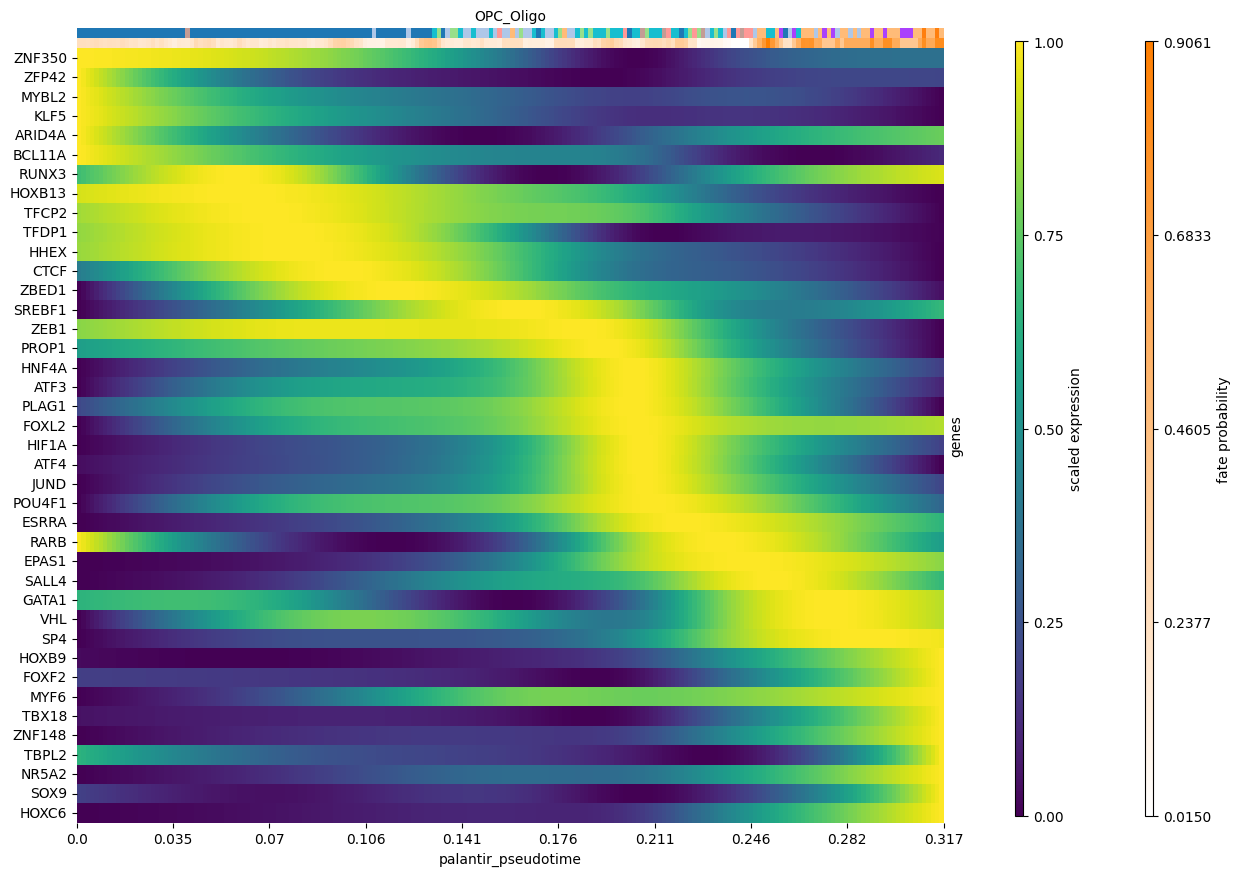

In [17]:
model = cr.models.GAMR(acts, n_knots=6, smoothing_penalty=10.0)


# compute putative drivers for the Beta trajectory
OPC_Oligo_drivers = g.compute_lineage_drivers(lineages="OPC_Oligo")

# plot heatmap
cr.pl.heatmap(
    acts,
    model=model,  # use the model from before
    lineages="OPC_Oligo",
    cluster_key="AggregatedLabel",
    show_fate_probabilities=True,
    genes=OPC_Oligo_drivers.head(40).index,
    time_key="palantir_pseudotime",
    figsize=(12, 10),
    show_all_genes=True,
    weight_threshold=(1e-3, 1e-3),
)

ERROR: Unable to duplicate function call using shadow `anndata.AnnData` object. Reason: `value.index does not match parent’s var names:
Index are different

Index length are different
[left]:  668, Index(['ABL1', 'AHR', 'AIRE', 'AP1', 'APEX1', 'AR', 'ARID1A', 'ARID3A',
       'ARID3B', 'ARID4A',
       ...
       'ZNF350', 'ZNF354C', 'ZNF362', 'ZNF382', 'ZNF384', 'ZNF395', 'ZNF436',
       'ZNF699', 'ZNF76', 'ZNF91'],
      dtype='object', length=668)
[right]: 16324, Index(['ENSG00000238009', 'LINC01409', 'LINC00115', 'FAM41C',
       'ENSG00000230699', 'NOC2L', 'KLHL17', 'ENSG00000272512', 'HES4',
       'ISG15',
       ...
       'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4',
       'MT-ND5', 'MT-ND6', 'MT-CYB'],
      dtype='object', name='external_gene_name', length=16324)`


  0%|          | 0/40 [00:00<?, ?gene/s]

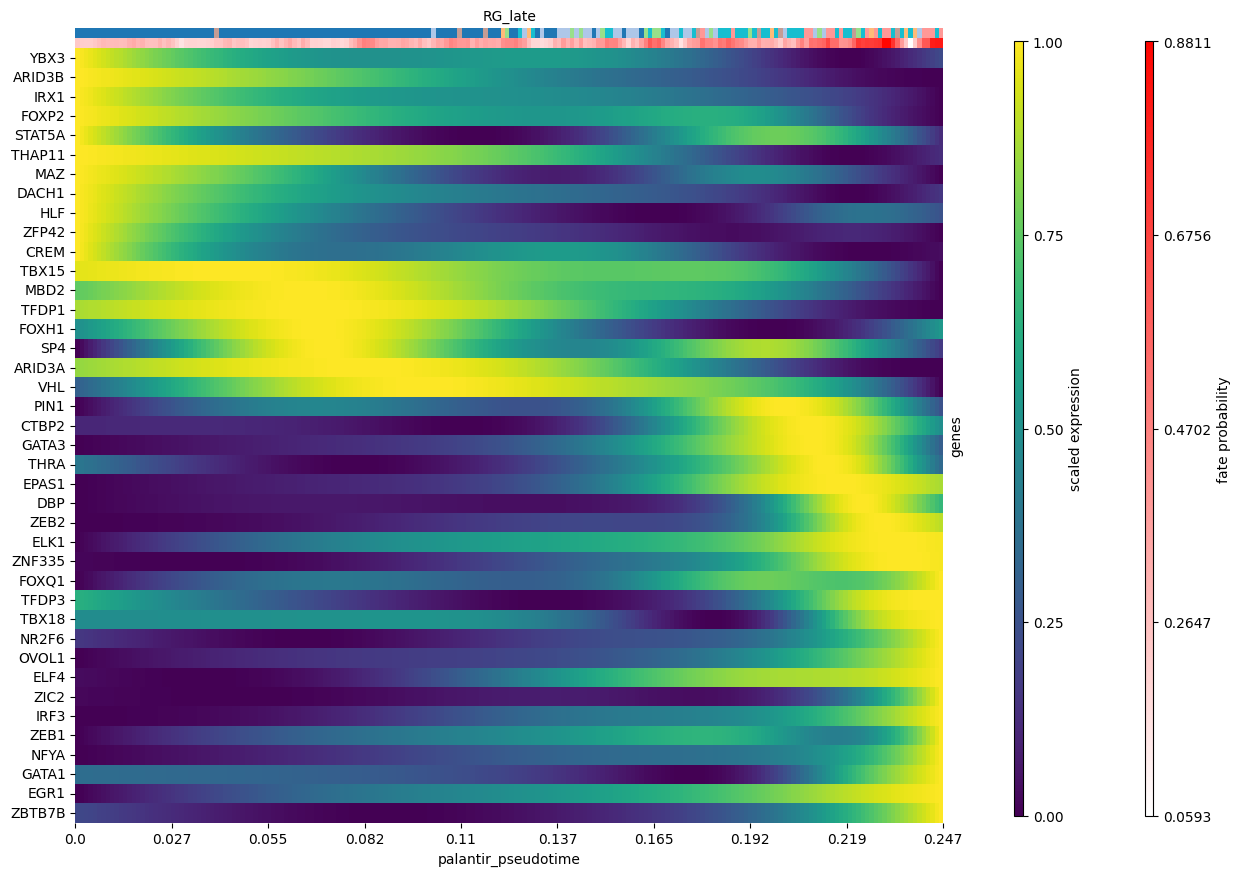

In [18]:
# compute putative drivers for the Beta trajectory
RG_late_drivers = g.compute_lineage_drivers(lineages="RG_late")

# plot heatmap
cr.pl.heatmap(
    acts,
    model=model,  # use the model from before
    lineages="RG_late",
    cluster_key="AggregatedLabel",
    show_fate_probabilities=True,
    genes=RG_late_drivers.head(40).index,
    time_key="palantir_pseudotime",
    figsize=(12, 10),
    show_all_genes=True,
    weight_threshold=(1e-3, 1e-3),
)

ERROR: Unable to duplicate function call using shadow `anndata.AnnData` object. Reason: `value.index does not match parent’s var names:
Index are different

Index length are different
[left]:  668, Index(['ABL1', 'AHR', 'AIRE', 'AP1', 'APEX1', 'AR', 'ARID1A', 'ARID3A',
       'ARID3B', 'ARID4A',
       ...
       'ZNF350', 'ZNF354C', 'ZNF362', 'ZNF382', 'ZNF384', 'ZNF395', 'ZNF436',
       'ZNF699', 'ZNF76', 'ZNF91'],
      dtype='object', length=668)
[right]: 16324, Index(['ENSG00000238009', 'LINC01409', 'LINC00115', 'FAM41C',
       'ENSG00000230699', 'NOC2L', 'KLHL17', 'ENSG00000272512', 'HES4',
       'ISG15',
       ...
       'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4',
       'MT-ND5', 'MT-ND6', 'MT-CYB'],
      dtype='object', name='external_gene_name', length=16324)`


  0%|          | 0/40 [00:00<?, ?gene/s]

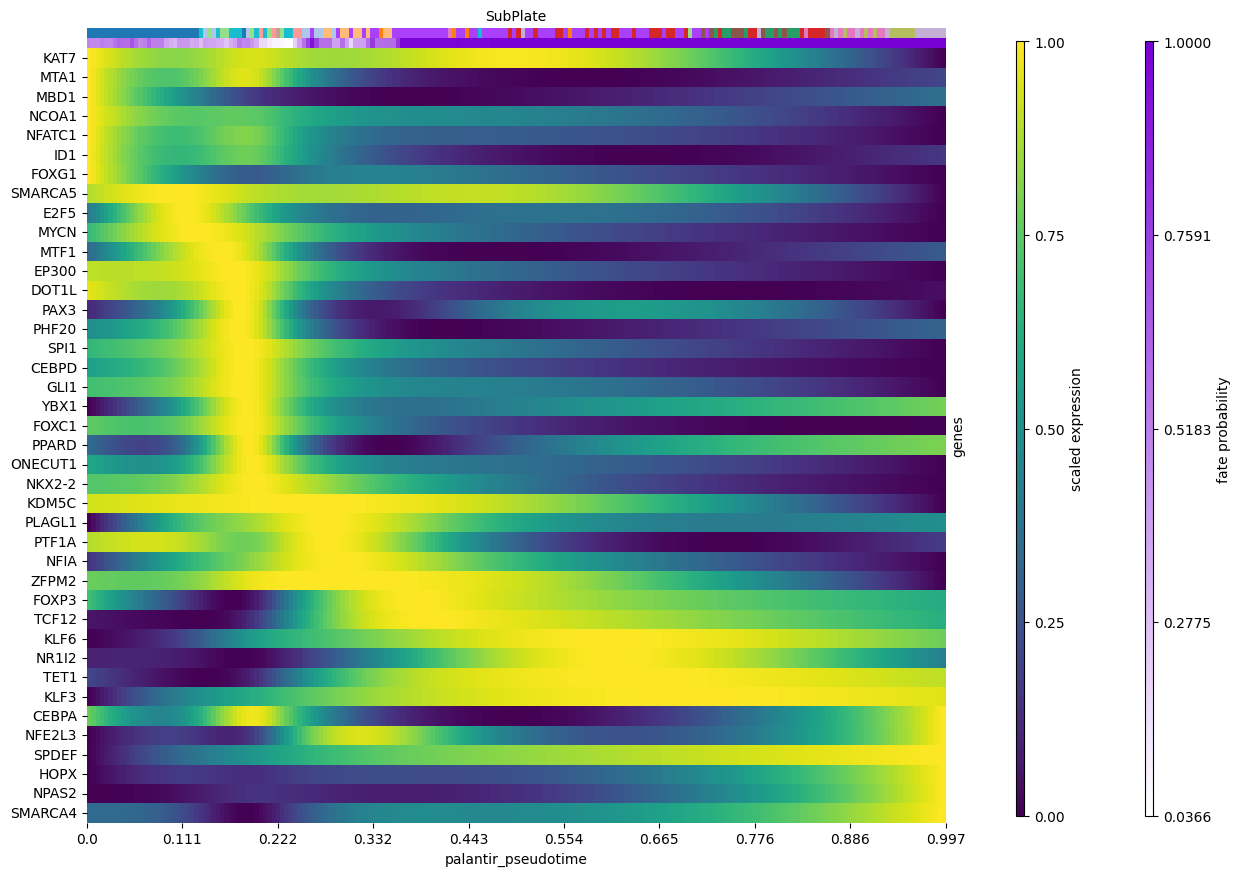

In [19]:
# compute putative drivers for the Beta trajectory
SubPlate_drivers = g.compute_lineage_drivers(lineages="SubPlate")

# plot heatmap
cr.pl.heatmap(
    acts,
    model=model,  # use the model from before
    lineages="SubPlate",
    cluster_key="AggregatedLabel",
    show_fate_probabilities=True,
    genes=SubPlate_drivers.head(40).index,
    time_key="palantir_pseudotime",
    figsize=(12, 10),
    show_all_genes=True,
    weight_threshold=(1e-3, 1e-3),
)